In [0]:
import numpy as np
import pandas as pd
import pylab as plt 

from google.colab import drive
import sqlite3
import seaborn as sns

from scipy.stats import binned_statistic, binned_statistic_2d
from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint


In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1 EDA on offers

In [0]:
df=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/pers_offers_final.pkl')
transactions_during_offer=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/trans_do.pkl')
transactions_outside_offer=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/trans_oo.pkl')

# not needed
portfolio=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/portfolio.pkl')
profile=pd.read_pickle(r'/content/gdrive/My Drive/UD/Sbux/data/profile.pkl')


rename_offers={'0b1e1539f2cc45b7b9fa7c272da2e1d7':'a',
 '2298d6c36e964ae4a3e7e9706d1fb8c2':'b',
 '2906b810c7d4411798c6938adc9daaa5':'c',
 '3f207df678b143eea3cee63160fa8bed':'d',
 '4d5c57ea9a6940dd891ad53e9dbe8da0':'e',
 '5a8bc65990b245e5a138643cd4eb9837':'f',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9':'g',
 'ae264e3637204a6fb9bb56bc8210ddfd':'h',
 'f19421c1d4aa40978ebb69ca19b0e20d':'i',
 'fafdcd668e3743c1bb461111dcafc2a4':'j'}


portfolio.rename(columns={'id':'offer'},inplace=True)
portfolio['offer']=portfolio['offer'].replace(rename_offers)
df['offer']=df['offer'].replace(rename_offers)


portfolio.sort_values(by='offer',inplace=True)


In [0]:
def plot_transactions(df,point_color='k',point_alpha=0.1, bin_color='r',bin_alpha=0.5, day_bins=True, week_bins=True, bin_week_color='g'):
  plt.plot(df['time'],df['payments'],'.',color=point_color,alpha=point_alpha)

  if day_bins:
    bin_meansD, bin_edgesD, binnumber = binned_statistic(df['time'],df['payments'], bins=range(0,31*24,24))
    plt.hlines(bin_meansD, bin_edgesD[:-1], bin_edgesD[1:], colors=bin_color, lw=3,alpha=bin_alpha)

  if week_bins:
    bin_means, bin_edges, binnumber = binned_statistic(df['time'],df['payments'], bins=range(0,31*24,24*7))
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors=bin_week_color, lw=5,alpha=bin_alpha);


def bin_transactions(df,xcol,ycol,xedges,yedges,count_bins,cmap='gnuplot',ylog=True,
                     xlabel='hours',ylabel_left='log10 purchase',ylabel_right='purchase [$]'):
  # plots 2d histogram of counts by time bin and transaction amount bin (log)
  
  fig, ax= plt.subplots()
  if ylog:
    yedges_bin=np.log10(yedges)
    yvalues=np.log10( df[ycol] )
  else:      
    yedges_bin=yedges
    yvalues=df[ycol]
    
  H, xedgesH, yedgesH = np.histogram2d(df[xcol],yvalues,bins=(xedges, yedges_bin))
  H=H.T

  norm = BoundaryNorm(count_bins,256) 
  X, Y = np.meshgrid(xedgesH, yedges_bin)
  cf=ax.pcolormesh(X, Y, H,cmap=plt.get_cmap(cmap) , norm=norm,zorder=1)
  
  plt.ylabel(ylabel_left)
  
  ax1=ax.twinx()
  ax1.set_yticks(yedgesH)
  yticks=['%g' % x for x in yedges]
  ax1.set_yticklabels(yticks)
  
  plt.xlabel(xlabel)
  plt.ylabel(ylabel_right)

  cbaxes = fig.add_axes([0.99, 0.1, 0.03, 0.8]) 

  cticks=['%d' % x for x in count_bins]


  cbar=fig.colorbar(cf,cax = cbaxes, spacing='uniform',norm=norm)
  cbar.set_ticks(count_bins)
  cbar.set_ticklabels(cticks)
  cbar.set_label('counts');

  #ax.vlines(xedges,Y.min(),Y.max(),lw=1,color='w',zorder=2);
  
  return fig,ax,ax1,Y.min(),Y.max() 


def plot_bn_offer(offer_rvc,num,den,alpha=0.05,xleg=1.1,**kwargs):
  # plots confidence intervals for offers type (a,b,c) vs date 
  
  cl,cu=proportion_confint(offer_rvc[num],offer_rvc[den],alpha=alpha)
  cmean=offer_rvc[num]/offer_rvc[den]

  cmean=cmean.unstack().T
  cl=cl.unstack().T
  cu=cu.unstack().T

  x=cmean.columns.values
  for off in cmean.index:
    ym=cmean.loc[off,:].values
    lb=cl.loc[off,:].values
    ub=cu.loc[off,:].values


    yerr_l = np.abs(lb - ym)
    yerr_u = np.abs(ub - ym)
    yerr = np.vstack((yerr_l, yerr_u))  
    plt.errorbar(x, ym, yerr=yerr,label=off,**kwargs)


  plt.legend(bbox_to_anchor=(xleg, 0.8)); 

  

def rvc_factor_plot(df,factor,xleg=1.15,**kwargs):
  rvc=df.groupby(by=[factor,'offer'])['received','viewed','completed'].agg('sum')

  plt.figure(figsize=(15,4));

  plt.subplot(121)
  plot_bn_offer(rvc,'viewed','received',alpha=0.05,xleg=xleg,**kwargs);
  rvc['vr']=rvc['viewed']/rvc['received']
  plt.xlabel(factor);
  plt.ylabel('fraction');
  plt.title('viewed/received @ alpha=0.05 ');


  plt.subplot(122)
  plot_bn_offer(rvc,'completed','viewed',alpha=0.05,xleg=xleg,**kwargs);
  plt.xlabel(factor);
  plt.title('completed/viewed @ alpha=0.05 ');
  

def plot_offers_of_customer(piv,customer,yc=0,step=0.1,plot_transactions=True,plot_offer_name=True,y_spacing=.2):
  # plots the offers and the transactions for a customer
  
  gg=piv.loc[(piv.person==customer),'offer_received' ].drop_duplicates()
  ind=gg.index.values

  viewed_offers=[]

  v_off_times=np.zeros((ind.shape[0],2))
  v_off_set=set([])

  c=0

  for n in ind:
    hh=plt.plot([piv.loc[n,'offer_received'],piv.loc[n,'offer_end']  ],[yc,yc],'o-',alpha=0.6)
    color=hh[0].get_color()
    
    if plot_offer_name:
      plt.text(  (piv.loc[n,'offer_received']+piv.loc[n,'offer_end'])/2,yc-y_spacing, piv.loc[n,'offer'] );
    
    if not np.isnan(piv.loc[n,'offer_viewed']):
      plt.plot([piv.loc[n,'offer_viewed'],piv.loc[n,'offer_end']  ],[yc,yc],'.-',alpha=1.0,color=color)
      viewed_offers.append(piv.loc[n,'offer'] )
      v_off_times[c,0]=piv.loc[n,'offer_viewed']
      v_off_times[c,1]=piv.loc[n,'offer_end']
      v_off_set=v_off_set.union(set( range(int(piv.loc[n,'offer_viewed']), int(piv.loc[n,'offer_end'])+0) ))
      c+=1


    yc+=step
  v_off_times=v_off_times[0:c,:]

  diff=np.diff(np.array(list(v_off_set)) )
  diff[diff>1]=0
  overlapping_offers_time=diff.sum()

  if plot_transactions:
    df=piv.loc[(piv.person==customer)]
    plt.plot(df['time'],df['payments'],'o',color='k',alpha=0.3)
  
  plt.xlabel('hours');
  plt.ylabel('purchases');
  
  
  return(viewed_offers,v_off_times,overlapping_offers_time)




In [0]:
display( df.head().iloc[:,0:20] )
display( df.head().iloc[:,20:40] )
display( df.head().iloc[:,40:50] )



,person,offer,offer_completed,offer_received,offer_viewed,reward,difficulty,duration,offer_type,web,email,mobile,social,duration_hours,offer_end,duration_viewed,duration_effective,viewed,rewarded,received
0,0009655768c64bdeb2e877511632db8f,c,576.0,576.0,NaN,2.0,10.0,7.0,discount,True,True,True,False,168.0,744.0,NaN,NaN,False,True,True
1,0009655768c64bdeb2e877511632db8f,d,NaN,336.0,372.0,NaN,0.0,4.0,informational,True,True,True,False,96.0,432.0,60.0,60.0,True,False,True
2,0009655768c64bdeb2e877511632db8f,f,NaN,168.0,192.0,NaN,0.0,3.0,informational,False,True,True,True,72.0,240.0,48.0,48.0,True,False,True
3,0009655768c64bdeb2e877511632db8f,i,414.0,408.0,456.0,5.0,5.0,5.0,bogo,True,True,True,True,120.0,528.0,72.0,72.0,True,True,True
4,0009655768c64bdeb2e877511632db8f,j,528.0,504.0,540.0,2.0,10.0,10.0,discount,True,True,True,True,240.0,744.0,204.0,204.0,True,True,True


,comp_not_viewed,completed,time,payments,Tpay_out,Npay_out,Tpay_offers_tot,Npay_offers_tot,Tpay_offer,Npay_offer,tot_gross_offer_time,tot_net_offers_time,tot_not_offers_time,age,became_member_on,gender,income,joined_year,joined_month,joined_week
0,True,False,NaN,NaN,NaN,NaN,127.6,8.0,NaN,NaN,1200.0,388.0,356.0,33,2017-04-21,M,72000.0,2017,4,16
1,False,False,414.0,8.57,NaN,NaN,127.6,8.0,8.57,1.0,1200.0,388.0,356.0,33,2017-04-21,M,72000.0,2017,4,16
2,False,False,228.0,22.16,NaN,NaN,127.6,8.0,22.16,1.0,1200.0,388.0,356.0,33,2017-04-21,M,72000.0,2017,4,16
3,False,True,528.0,14.11,NaN,NaN,127.6,8.0,14.11,1.0,1200.0,388.0,356.0,33,2017-04-21,M,72000.0,2017,4,16
4,False,True,552.0,13.56,NaN,NaN,127.6,8.0,82.76,5.0,1200.0,388.0,356.0,33,2017-04-21,M,72000.0,2017,4,16


,gender_num,user_time,Avg_pay_offer,Avg_pay_offers,Avg_pay_outside,Avg_D_O,Avg_D_OS
0,1,461,NaN,0.328866,NaN,NaN,NaN
1,1,461,0.142833,0.328866,NaN,NaN,NaN
2,1,461,0.461667,0.328866,NaN,NaN,NaN
3,1,461,0.195972,0.328866,NaN,NaN,NaN
4,1,461,0.405686,0.328866,NaN,NaN,NaN


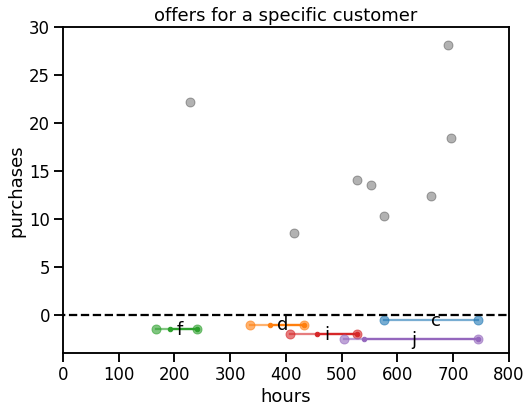

In [0]:
sns.set_context('talk')

fig=plt.figure(figsize=(8,6))
customer="0009655768c64bdeb2e877511632db8f"
plot_offers_of_customer(df,customer,yc=-.5,step=-0.5,y_spacing=0.6,plot_transactions=True);
plt.title('offers for a specific customer');
plt.plot([-10,800],[0,0],'k--')
plt.axis([0,800,-4,30]);
#plt.savefig(r'/content/gdrive/My Drive/UD/Sbux/test.svg')

days when the offers are sent: [ 0.  7. 14. 17. 21. 24.]
hours when the offers are sent: [  0. 168. 336. 408. 504. 576.]


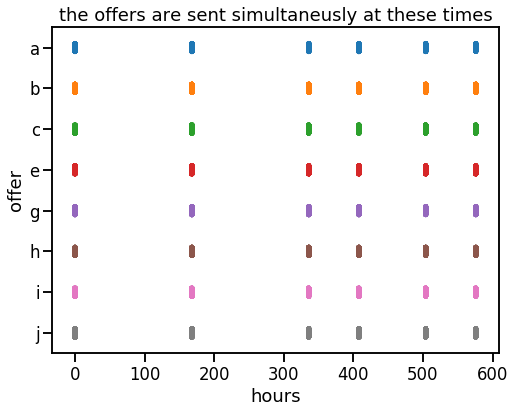

In [0]:
# how are offers sent

sns.set_context('talk')

fig=plt.figure(figsize=(8,6))

sns.stripplot(y="offer", x="offer_received", data=df.dropna().sort_values(by=['offer']),jitter=True);

offers_start_times=np.unique(df.loc[(df.offer=='a'),'offer_received'].values)
plt.title('the offers are sent simultaneusly at these times')
plt.xlabel('hours')

print('days when the offers are sent:' ,offers_start_times/24)
print('hours when the offers are sent:' ,offers_start_times)

Text(0.5, 0, 'hours')

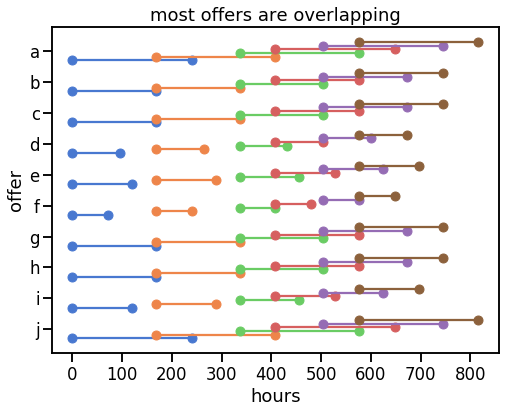

In [0]:
sns.set_context('talk')

fig=plt.figure(figsize=(8,6))

xx=offers_start_times
spacing=.3
yy=np.linspace(-spacing,spacing,xx.shape[0])
yy2=np.vstack((yy,yy))

c=portfolio.shape[0]
ylabel=[]
yticks=[]

sns.set_palette('muted',offers_start_times.shape[0])
for ind in portfolio.index:
  xx2=np.vstack((xx,xx+portfolio.loc[ind,'duration']*24)).T
  plt.plot(xx2.T,yy2+c,'o-')
  ylabel.append(c)
  yticks.append(portfolio.loc[ind,'offer'])
  c-=1
plt.xlabel('offer_received')
plt.yticks(ylabel,yticks);
plt.ylabel('offer');
plt.title('most offers are overlapping');
plt.xlabel('hours')

In [0]:
# numbers of offers sent, viewed and completed

piv_rec=df.pivot_table(index=['offer'],columns=['offer_received'],values=['person'], aggfunc='count').loc[:,'person']
number_of_persons=np.unique(df['person']).shape[0]

piv_view=df.pivot_table(index=['offer'],columns=['offer_received'],values=['viewed'], aggfunc='sum').loc[:,'viewed'].astype(int)

piv_compl=df.pivot_table(index=['offer'],columns=['offer_received'],values=['completed'], aggfunc='sum').loc[:,'completed'].astype(int)

view_perc=100.*piv_view/piv_rec
compl_perc=100.*piv_compl/piv_view

offer_rvc=pd.concat((piv_rec.unstack(),piv_view.unstack(),piv_compl.unstack()),axis=1 )
offer_rvc.columns=['received','viewed','completed']
offer_rvc.head()

received  viewed  completed
offer_received offer                             
0.0            a          1911    1151        870
               b          3049    3040       2579
               c          2062    1623       1217
               d          1534    1072          0
               e          2309    2298       1178

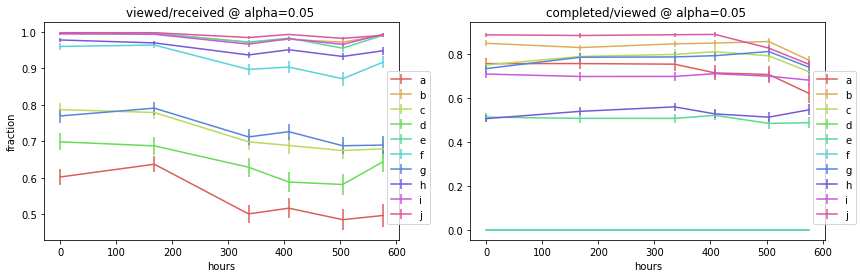

In [0]:
plt.figure(figsize=(14,4));

plt.subplot(121)
plot_bn_offer(offer_rvc,'viewed','received',alpha=0.05);
plt.xlabel('hours');
plt.ylabel('fraction');
plt.title('viewed/received @ alpha=0.05 ');


plt.subplot(122)
plot_bn_offer(offer_rvc,'completed','viewed',alpha=0.05);
plt.xlabel('hours');
plt.title('completed/viewed @ alpha=0.05 ');


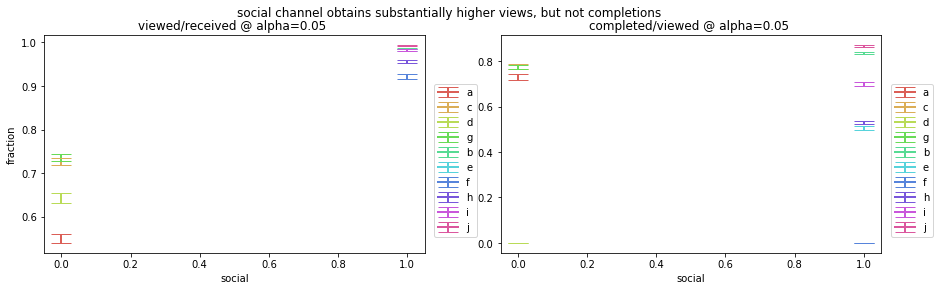

In [0]:
rvc_factor_plot(df,'social',lw=2,capsize=10);
plt.suptitle('social channel obtains substantially higher views, but not completions');

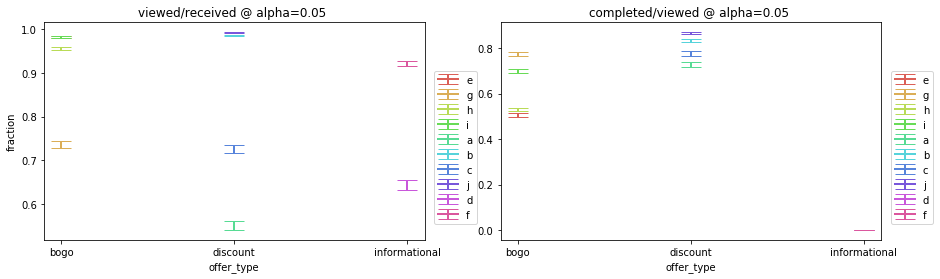

In [0]:
rvc_factor_plot(df,'offer_type',lw=2,capsize=10);


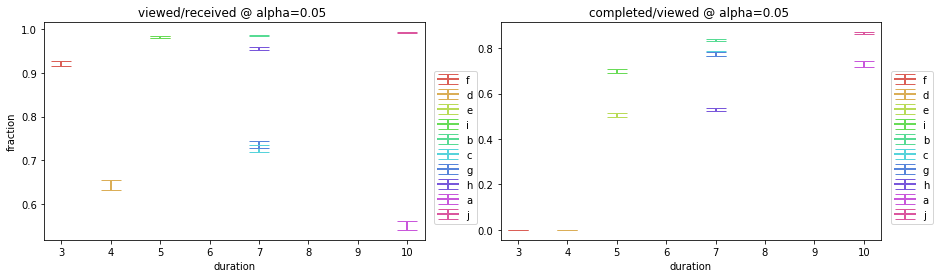

In [0]:
rvc_factor_plot(df,'duration',lw=2,capsize=10);

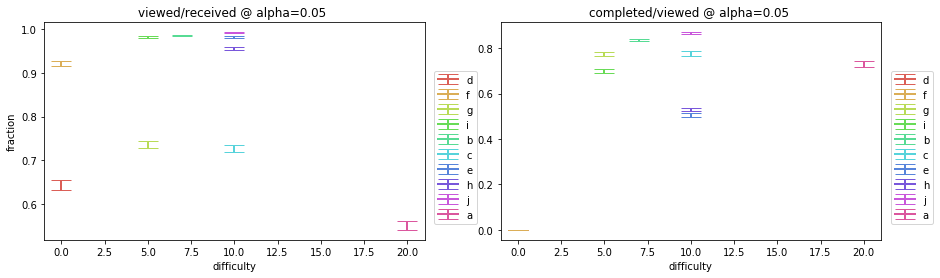

In [0]:
rvc_factor_plot(df,'difficulty',lw=2,capsize=10);

In [0]:
# it seems that many offers were sent and offers are also highly overlapping
offers_per_person=df.pivot_table(index=['person'],columns=['offer_received'],values=['offer'], aggfunc='count').loc[:,'offer'].fillna(0)
offers_per_person.head()

offer_received,0.0,168.0,336.0,408.0,504.0,576.0
person,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,1.0,1.0,1.0,5.0,1.0
00116118485d4dfda04fdbaba9a87b5c,0.0,1.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,1.0,3.0,0.0
0020c2b971eb4e9188eac86d93036a77,4.0,1.0,0.0,1.0,1.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,4.0,4.0,1.0,2.0,0.0


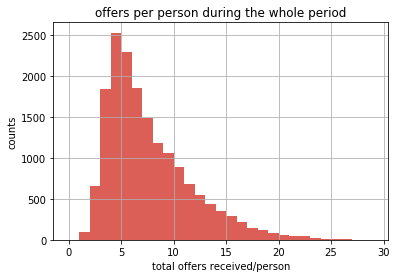

In [0]:
offers_per_person.sum(axis=1).hist(bins=range(0,30));
plt.title('offers per person during the whole period');
plt.xlabel('total offers received/person');
plt.ylabel('counts');


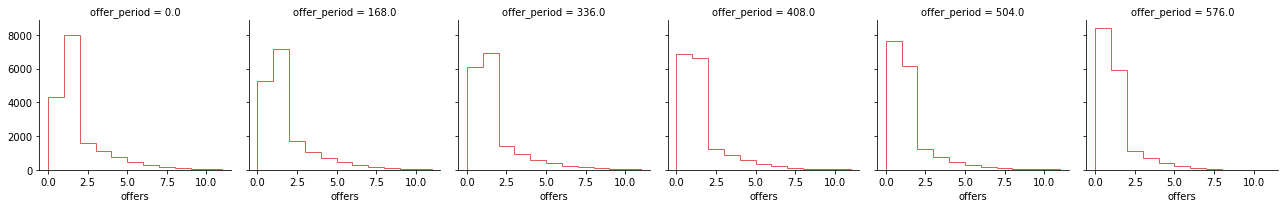

In [0]:
opp=offers_per_person.stack().reset_index().rename(columns={0:'offers','offer_received':'offer_period'})
g = sns.FacetGrid(opp, col="offer_period");
g.map(plt.hist, "offers",histtype='step',bins=range(0,12));



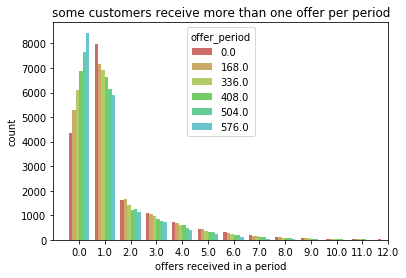

In [0]:
sns.countplot(x='offers',data=opp,hue='offer_period');
plt.xlim(-1,12);
plt.title('some customers receive more than one offer per period')
plt.xlabel('offers received in a period');


0c6ba803d2c84d71b0f0980a03912398


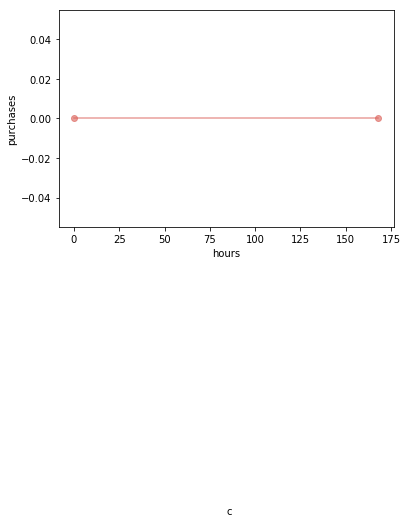

In [0]:
total_offers_per_person=offers_per_person.sum(axis=1)
# total_offers_per_person.index
customer=total_offers_per_person[total_offers_per_person==1.0].index[5]

print(customer)

plot_offers_of_customer(df,customer,yc=0,step=0.1,plot_transactions=True);
# plt.title('Some customers experience many offers');



(0, 50)

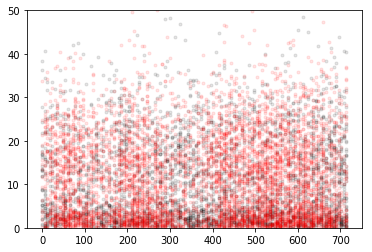

In [0]:
# transactions_outside_offer.head()
customers=list( df.loc[(df.offer=='a') & (df.offer_received==336),'person'].values )

plot_transactions(transactions_outside_offer.loc[transactions_outside_offer.person.isin(customers)],point_color='k',point_alpha=.1, bin_color='r',bin_alpha=0.5, day_bins=False, week_bins=False, bin_week_color='g')
plot_transactions(transactions_during_offer.loc[transactions_during_offer.person.isin(customers)],point_color='r',point_alpha=.1, bin_color='r',bin_alpha=0.5, day_bins=False, week_bins=False, bin_week_color='g')
plt.ylim(0,50)

In [0]:
po_c=transcript.loc[(transcript.event=='offer received'),:].groupby(by=['person','offer','time'])['time'].agg('count')
assert po_c.max()==1, "some users received twice the same offer in the same time slot"

po_c=transcript.loc[(transcript.event=='offer received'),:].groupby(by=['person','offer'])['event'].agg('count')
po_c.hist(bins=range(0,6))
plt.yscale('log')

plt.xlabel('number of times the same offer is received')
plt.ylabel('frequency');

NameError: ignored

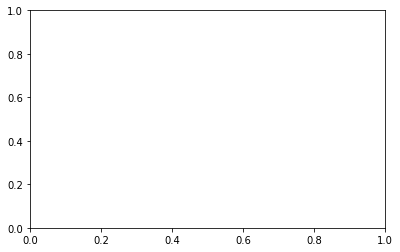

In [0]:
plt.figure(figsize=(14,4));

plt.subplot(121)
plt.hist(total_purchase_outside_num.values,bins=range(0,15),histtype='step',lw=2,label='outside');
plt.hist(t_offers_num.values,bins=range(0,15),histtype='step',lw=2,label='during');
plt.xlabel('number of purchases per customer');
plt.ylabel('frequency');

plt.subplot(122)
plt.hist(total_purchase_outside.values,bins=20,histtype='step',lw=2,label='outside');
plt.hist(t_offers.values,bins=20,histtype='step',lw=2,label='during');
plt.xlabel('amount spent per customer');
plt.ylabel('Log frequency');
plt.yscale('log');
plt.suptitle('customer behavior outside/during offers');

# 2 Offers viewed